## CIFAR-10 이미지 생성하기

In [1]:
import tensorflow as tf
import imageio
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from tensorflow.keras import layers, Input
from matplotlib.pylab import rcParams
import os
import time
import glob
from IPython import display

#### 이미지 다운로드

In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _)  = cifar10.load_data()

In [3]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


#### 이미지 정규화

In [4]:
train_x = (train_x -127.5) / 127.5  # 이미지를 [-1,1]로 정규화
print("max pixel : ", train_x.max())
print("min pixel : ", train_x.min())

max pixel :  1.0
min pixel :  -1.0


In [5]:
train_x= train_x.reshape(train_x.shape[0], 32,32,3).astype('float32')
train_x.shape

(50000, 32, 32, 3)

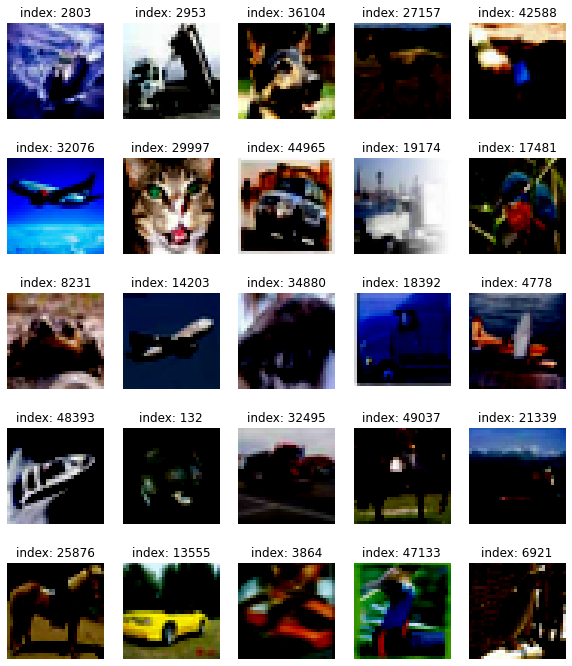

In [6]:
plt.figure(figsize=(10,12))

for i in range(25):
    plt.subplot(5,5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow(np.clip(train_x[random_index].reshape(32,32,3),0,1))
    plt.title(f'index: {random_index}')
    plt.axis('off')

plt.show()

In [7]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

#### 생성자 모델 설계

In [9]:
def make_generator_model():
    model = tf.keras.Sequential()

    # First: Dense Layer
    # noise vector를 인풋으로 받는다 .
    # case #1
    #model.add(Input(shape=(200,)))
    #model.add(layers.Dense(8*8*256, use_bias=False))
    # case #2
    #model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    #case #3
    model.add(layers.Dense(8*8*256, use_bias=False, input_dim=100))
    # BatchNormalization의 역할은 input_shape에 대한 정규화
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    #Second: Reshape Layer
    model.add(layers.Reshape((8, 8, 256)))

    #Third: Conv2DTranspose Layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5,5), strides=(1,1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

        # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False,  activation='tanh'))

    return model;

In [10]:
def make_generator_model_v1():
    model = tf.keras.Sequential()

    # First: Dense Layer
    # noise vector를 인풋으로 받는다 .
    # case #1
    #model.add(Input(shape=(200,)))
    #model.add(layers.Dense(8*8*256, use_bias=False))
    # case #2
    #model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    #case #3
    model.add(layers.Dense(8*8*512, use_bias=False, input_dim=50))
    # BatchNormalization의 역할은 input_shape에 대한 정규화
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    #Second: Reshape Layer
    model.add(layers.Reshape((8, 8, 512)))

    #Third: Conv2DTranspose Layer
    model.add(layers.Conv2DTranspose(256, kernel_size=(5,5), strides=(1,1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    #Third: Conv2DTranspose Layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5,5), strides=(1,1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

        # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False,  activation='tanh'))

    return model;

#### 생성자 모델 생성

In [11]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 128)        5

In [12]:
generator_v1 = make_generator_model_v1()
generator_v1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 32768)             1638400   
                                                                 
 batch_normalization_3 (Batc  (None, 32768)            131072    
 hNormalization)                                                 
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 32768)             0         
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 8, 8, 256)        3276800   
 ranspose)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 8, 8, 256)       

In [13]:
noise = tf.random.normal([1,100])

In [14]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

In [15]:
noise_v1 = tf.random.normal([1,50])

#### 초기 Noise 벡터값을 50과 100으로 주고 차이점 확인

In [16]:
generated_image_v1 = generator_v1(noise_v1, training=False)
generated_image_v1.shape

TensorShape([1, 32, 32, 3])

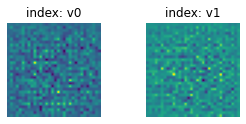

In [17]:
plt.figure(figsize=(12,10))
plt.subplot(5,5,1)
plt.imshow(generated_image[0, :, :, 0])
plt.title(f'index: v0')
plt.axis('off')
plt.subplot(5,5,2)
plt.imshow(generated_image_v1[0, :, :, 0])
plt.title(f'index: v1')
plt.axis('off')
plt.show()

#### 판별자 모델 설계

In [18]:
def make_discriminator_model():
    #Start
    model = tf.keras.Sequential()

    #First Conv2D Layer
    model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[32,32,3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    #Second: Conv2D layer
    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    #Second: Conv2D layer
    model.add(layers.Conv2D(256, (5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())
  
    #Third: Flattern layer
    model.add(layers.Flatten())

    # Fourth: Dense layer
    model.add(layers.Dense(1))

    return model

#### 판별자 모델 생성

In [19]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)        

In [20]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00165088]], dtype=float32)>

In [21]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [22]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [23]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss

    return total_loss

In [24]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))

    return real_accuracy, fake_accuracy

In [25]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [26]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [27]:
noise_dim_v1 = 50
num_examples_to_generate_v1 = 16

seed_v1 = tf.random.normal([num_examples_to_generate_v1, noise_dim_v1])
seed_v1.shape

TensorShape([16, 50])

#### 훈련 스탭 설계
다른점 
- noise vector 100으로 설정
- epoch 100

In [28]:
@tf.function  #이 데코레이터는 우리가 직접 session을 열어서 학습했다가, 학습이 완료되면 다시 닫아주는 등의 번거로운 과정을 내부적으로 처리해서 더욱 편리하게 학습시킬 수 있게 해준다.
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

#### 훈련스텝 설계 v1

- 생성모델에서 레이어 추가
- noise vector 50으로 설정
- epoch 200

In [29]:
@tf.function  #이 데코레이터는 우리가 직접 session을 열어서 학습했다가, 학습이 완료되면 다시 닫아주는 등의 번거로운 과정을 내부적으로 처리해서 더욱 편리하게 학습시킬 수 있게 해준다.
def train_step_v1(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim_v1])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape1, tf.GradientTape() as disc_tape1:  #(3) tf.GradientTape() 오픈
        generated_images = generator_v1(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape1.gradient(gen_loss, generator_v1.trainable_variables)
    gradients_of_discriminator = disc_tape1.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator_v1.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

### 이미지 저장

In [30]:
def generate_and_save_images(model, epoch, it, sample_seeds):
    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow(predictions[i, :, :, 0])
        plt.axis('off')
 #   plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
 #                   .format(os.getenv('HOME'), epoch, it))
    plt.savefig('{}/.jupyter/kernels/aiffel/exp11/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))
    plt.show()

In [31]:
def generate_and_save_images_v1(model, epoch, it, sample_seeds):
    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow(predictions[i, :, :, 0])
        plt.axis('off')
 #   plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
 #                   .format(os.getenv('HOME'), epoch, it))
    plt.savefig('{}/.jupyter/kernels/aiffel/exp11/cifar10/generated_samples_v1/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))
    plt.show()

In [32]:
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss
    plt.subplot(211)
    plt.plot(history['gen_loss'])
    plt.plot(history['disc_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('batch iters')
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')

    # summarize history for accuracy
    plt.subplot(212)
    plt.plot(history['fake_accuracy'])
    plt.plot(history['real_accuracy'])
    plt.title('discriminator accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('batch iters')
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')

    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/.jupyter/kernels/aiffel/exp11/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    #plt.savefig('{}/.jupyter/kernels/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
     #               .format(os.getenv('HOME'), epoch))
    plt.show()

In [33]:
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history_v1(history, epoch):
    # summarize history for loss
    plt.subplot(211)
    plt.plot(history['gen_loss'])
    plt.plot(history['disc_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('batch iters')
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')

    # summarize history for accuracy
    plt.subplot(212)
    plt.plot(history['fake_accuracy'])
    plt.plot(history['real_accuracy'])
    plt.title('discriminator accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('batch iters')
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')

    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/.jupyter/kernels/aiffel/exp11/cifar10/training_history_v1/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    #plt.savefig('{}/.jupyter/kernels/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
     #               .format(os.getenv('HOME'), epoch))
    plt.show()

In [34]:
#checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'
checkpoint_dir = os.getenv('HOME')+'/.jupyter/kernels/aiffel/exp11/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [35]:
#checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'
checkpoint_dir_v1 = os.getenv('HOME')+'/.jupyter/kernels/aiffel/exp11/cifar10/training_checkpoints_v1'

checkpoint_prefix_v1 = os.path.join(checkpoint_dir, "ckpt")
checkpoint_v1 = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

#### 모델 훈련

In [36]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [37]:
def train_v1(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step_v1(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images_v1(generator_v1, epoch+1, it+1, seed_v1)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint_v1.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images_v1(generator_v1, epochs, it, seed_v1)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history_v1(history, epoch)

In [38]:
save_every = 10
EPOCHS = 100

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [39]:
save_every_v1 = 10
EPOCHS_v1 = 200

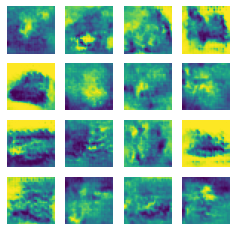

Time for training : 1040 sec


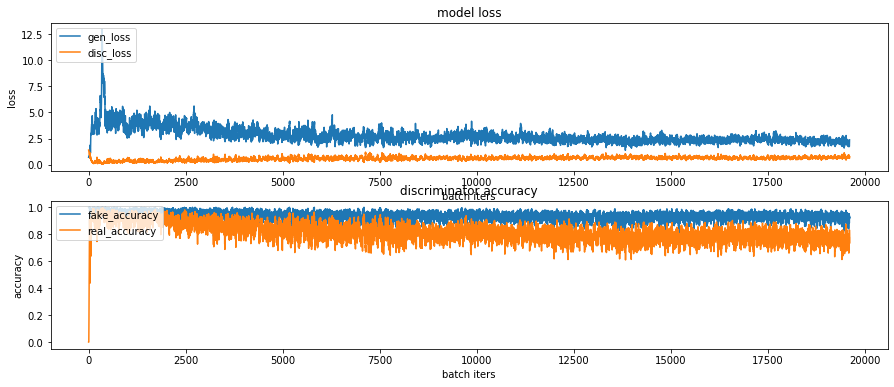

CPU times: user 17min 23s, sys: 19.8 s, total: 17min 42s
Wall time: 17min 21s


In [40]:
%%time
history = train(train_dataset, EPOCHS, save_every)

In [41]:
anim_file = os.getenv('HOME')+'/.jupyter/kernels/aiffel/exp11/cifar10/cifar10_mnist_dcgan.gif'
#anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/.jupyter/kernels/aiffel/exp11/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/.jupyter/kernels/aiffel/exp11/cifar10/cifar10_mnist_dcgan.gif

#!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-rw-r-- 1 bckang bckang 1884421 12월 19 15:07 /home/bckang/.jupyter/kernels/aiffel/exp11/cifar10/cifar10_mnist_dcgan.gif


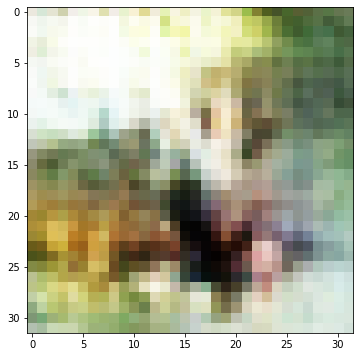

In [61]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

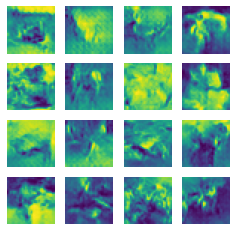

Time for training : 2713 sec


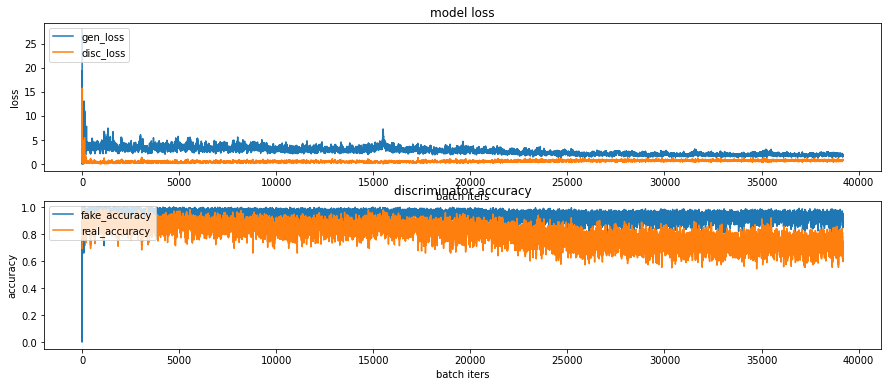

CPU times: user 45min 1s, sys: 39.2 s, total: 45min 40s
Wall time: 45min 15s


In [44]:
%%time
history_v1 = train_v1(train_dataset, EPOCHS_v1, save_every_v1)

In [45]:
anim_file = os.getenv('HOME')+'/.jupyter/kernels/aiffel/exp11/cifar10/cifar10_mnist_dcgan_v1.gif'
#anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/.jupyter/kernels/aiffel/exp11/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/.jupyter/kernels/aiffel/exp11/cifar10/cifar10_mnist_dcgan_v1.gif

#!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-rw-r-- 1 bckang bckang 1884421 12월 19 15:54 /home/bckang/.jupyter/kernels/aiffel/exp11/cifar10/cifar10_mnist_dcgan_v1.gif


### v1모델의 경우 결과 이미지

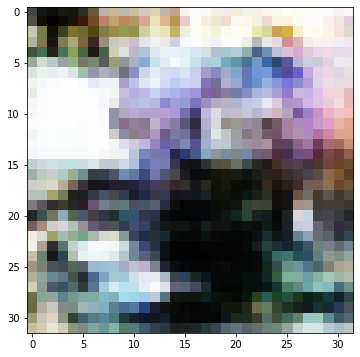

In [59]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints_v1'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint_v1.restore(latest)

generator = checkpoint_v1.generator
discriminator = checkpoint_v1.discriminator

noise = tf.random.normal([1, 50])
generated_image = generator_v1(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

## 회고

## process flow
- 데이터셋/다운로드 
- 이미지 정규화( -1 ~ 1 ) 사이의 값으로 변환 
- 생성자 모델 설계<br>
  .. Noise 벡터를 입력으로 하고 8*8*256노드를 출력하도록 Dense Lay추가<br>
  .. BatchNormalization() -> input에 normalization<br>
  .. 활성화 함수 추가 ( LeakyReLU) -> -값도 있으므로 모두 무시하지 않고 반영을 하기 위함<br>
  .. 1차원을 3차원으로 Reshape Layer 추가 <br>
- 생성자 모델 생성
- 판별자 모델 설계
- 판별자 모델 생성
- Train-step 설정
- train
- 결과 이미지 확인

## 모델에 대한 변경 
1. Noise벡터의 값 변경 + 생성자의 Layer를 추가 + epoch를 두배로 늘려서 수행 <br>
   Version 1으로 모델에서는 v1으로 표기함<br>
   => 초기 이미지가 선명하지 않는 경우는 판별자와 생성자간 loss가 크지 않다가 일정 수준이 지나면 <br>
      loss폭이 점점 커져감 <br>
      
   => 생성자 모델에 대한 보완이 필요할 것으로 생각됨<br>
   
2. epoch의 수를 늘리면 좀 더 나은 생성자모델을 얻어질것으로 생각됨
      
